### <span style="color:orange"> Install CUDA (GPU drivers from NVIDIA) </span>

- import Pkg; Pkg.add("CUDA");

In [3]:
#import Pkg; Pkg.add("CUDA");
using CUDA

#### By default, Flux will run the checks on your system to see if it can support GPU functionality. You can check if Flux identified a valid GPU setup by typing the following:

In [4]:
CUDA.functional() #check if Flux can find your GPU

false

#### you need to **->move<-** <u>model weights</u> and <u>data</u> to the GPU and Flux will handle it.

- you need to tell Flux that the weights and the data need to go to the GPU to be used in the computation by the GPU

In [17]:
using Flux, Statistics, ProgressMeter
using Plots 
using StatsBase, Random

In [8]:
noisy = rand(Float32, 2, 1000)                                    # 2×1000 Matrix{Float32}
truth = [xor(col[1]>0.5, col[2]>0.5) for col in eachcol(noisy)]   # 1000-element Vector{Bool}

# Define our model, a multi-layer perceptron with one hidden layer of size 3:
model = Chain(
    Dense(2 => 3, tanh),   # activation function inside layer
    BatchNorm(3),
    Dense(3 => 2),
    softmax) |> gpu        # move model to GPU, if available

# The model encapsulates parameters, randomly initialised. Its initial output is:
out1 = model(noisy |> gpu) |> cpu                                 # 2×1000 Matrix{Float32}

# To train the model, we use batches of 64 samples, and one-hot encoding:
target = Flux.onehotbatch(truth, [true, false])                   # 2×1000 OneHotMatrix
loader = Flux.DataLoader((noisy, target) |> gpu, batchsize=64, shuffle=true);
# 16-element DataLoader with first element: (2×64 Matrix{Float32}, 2×64 OneHotMatrix)

optim = Flux.setup(Flux.Adam(0.01), model)  # will store optimiser momentum, etc.

# Training loop, using the whole data set 1000 times:
losses = []
@showprogress for epoch in 1:1_000
    for (x, y) in loader
        loss, grads = Flux.withgradient(model) do m
            # Evaluate model and loss inside gradient context:
            y_hat = m(x)
            Flux.crossentropy(y_hat, y)
        end
        Flux.update!(optim, model, grads[1])
        push!(losses, loss)  # logging, outside gradient context
    end
end

optim # parameters, momenta and output have all changed
out2 = model(noisy |> gpu) |> cpu  # first row is prob. of true, second row p(false)

mean((out2[1,:] .> 0.5) .== truth)  # accuracy 94% so far!

┌ Info: The GPU function is being called but the GPU is not accessible. 
│ Defaulting back to the CPU. (No action is required if you want to run on the CPU).
└ @ Flux /home/resort/.julia/packages/Flux/v79Am/src/functor.jl:218
Progress: 100%|█████████████████████████████████████████| Time: 0:00:34


0.966

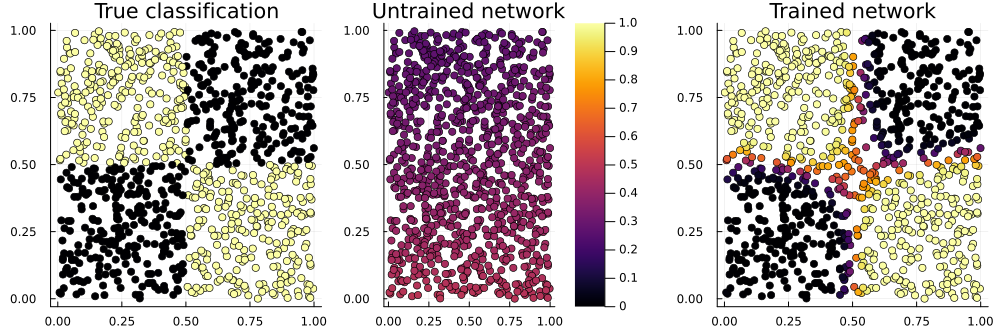

In [11]:
p_true = scatter(noisy[1,:], noisy[2,:], zcolor=truth, title="True classification", legend=false)
p_raw =  scatter(noisy[1,:], noisy[2,:], zcolor=out1[1,:], title="Untrained network", label="", clims=(0,1))
p_done = scatter(noisy[1,:], noisy[2,:], zcolor=out2[1,:], title="Trained network", legend=false)

plot(p_true, p_raw, p_done, layout=(1,3), size=(1000,330))

## <span style="color:orange"> Keyword `gpu` is a function to put models and data onto the GPU </span>

- Float32 is the typical single precision on GPUs

In [36]:
using RDatasets
iris = dataset("datasets", "iris");

In [37]:
typeof(iris)
display( iris[1:3,:])

Row,SepalLength,SepalWidth,PetalLength,PetalWidth,Species
,Float64,Float64,Float64,Float64,Cat…
1,5.1,3.5,1.4,0.2,setosa
2,4.9,3.0,1.4,0.2,setosa
3,4.7,3.2,1.3,0.2,setosa


In [38]:
features = iris[:,1:4]
features = Matrix{Float32}(features) 
println( typeof( features ) )
targets = iris[:,5];

Matrix{Float32}


In [39]:
length( unique( iris[:,end] ) )

3

In [40]:
length( iris[:,end] )

150

In [41]:
odd_inds = findall( mod.(1:150,2) .== 1)
even_inds = findall( mod.(1:150,2) .== 0);

In [42]:
x_train , x_test = features[odd_inds,:] , features[even_inds,:];
y_train , y_test = targets[odd_inds] , targets[even_inds];
println( "x_train size before ", size(x_train) )
x_train = x_train'
x_test = x_test'
println( "x_train size after ", size(x_train) )

x_train size before (75, 4)
x_train size after (4, 75)


In [43]:
#we need to make 1-hot encoding of the categorical values
species = unique( iris[:,end] )
y_train = Flux.onehotbatch( y_train , species )
display( size(y_train) )
y_test = Flux.onehotbatch( y_test , species )

(3, 75)

3×75 OneHotMatrix(::Vector{UInt32}) with eltype Bool:
 1  1  1  1  1  1  1  1  1  1  1  1  1  …  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅
 ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅     ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅
 ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅     1  1  1  1  1  1  1  1  1  1  1  1

In [46]:
#put onto the GPU
species |> gpu
x_train |> gpu
x_test |> gpu
y_train |> gpu
y_test |> gpu

3×75 OneHotMatrix(::Vector{UInt32}) with eltype Bool:
 1  1  1  1  1  1  1  1  1  1  1  1  1  …  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅
 ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅     ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅
 ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅     1  1  1  1  1  1  1  1  1  1  1  1

    
- if a GPU is -not- present it will do nothing, it runs on the GPU if the library CUDA.jl loads successfully 
- this function moves data to the GPU from the CPU space  
                    
![by Damien Benveniste ](./cpugputpu.jpg)

(TPUs are not recommended to sequential models like LSTMs and they require longer runs to derive benefit over the GPU)

In [26]:
#make a model for predicting the species (categorical output)
model_iris = Chain( Dense( 4=>8, relu ) , Dense( 8=>3, sigmoid ) , softmax ) |> gpu

Chain(
  Dense(4 => 8, relu),                  # 40 parameters
  Dense(8 => 3, σ),                     # 27 parameters
  NNlib.softmax,
)                   # Total: 4 arrays, 67 parameters, 524 bytes.

### <span style="color:orange"> The data and model is brought back from the GPU to the CPU with the function `cpu` </span>

- if the data has been moved to the GPU it is necessary to run `cpu` in order to do things like plot the data

In [54]:
#put back onto the CPU
species |> gpu
x_train |> cpu
x_test |> cpu
y_train |> cpu
y_test |> cpu

3×75 OneHotMatrix(::Vector{UInt32}) with eltype Bool:
 1  1  1  1  1  1  1  1  1  1  1  1  1  …  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅
 ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅     ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅
 ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅     1  1  1  1  1  1  1  1  1  1  1  1

In [49]:
println( "model output = " , model_iris( x_train[:,1] ) )
println( "category output predicted ('one-cold') = " , Flux.onecold( model_iris(x_train[:,1]), species ) )
println( "true output label = " , Flux.onecold( y_train[:,1], species ) )
#try out the cross entropy
println( "cross entropy of prediction and target = " , Flux.crossentropy( model_iris( x_train[:,1] ) , y_train[:,1] ) )
println( "cross entropy of predictions and multiple targets = " , Flux.crossentropy( model_iris( x_train[:,1:20] ) , y_train[:,1:20] ) )
hits = Flux.onecold( model_iris( x_train ) , species ) .== Flux.onecold( y_train , species )
accuracy = 100 * sum( hits ) / length( hits )
println( "init accuracy = ", accuracy , "%")

model output = Float32[0.562212, 0.22195598, 0.21583201]
category output predicted ('one-cold') = setosa
true output label = setosa
cross entropy of prediction and target = 0.57587606
cross entropy of predictions and multiple targets = 0.5770652
init accuracy = 33.333333333333336%


In [55]:
#put back onto the GPU
species |> gpu
x_train |> gpu
x_test |> gpu
y_train |> gpu
y_test |> gpu

3×75 OneHotMatrix(::Vector{UInt32}) with eltype Bool:
 1  1  1  1  1  1  1  1  1  1  1  1  1  …  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅
 ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅     ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅
 ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅     1  1  1  1  1  1  1  1  1  1  1  1

In [51]:
#pack the data and put onto the gpu
data = Flux.DataLoader( (x_train, y_train) , batchsize=10 , shuffle=true ) |> gpu

MLUtils.DataLoader{Tuple{LinearAlgebra.Adjoint{Float32, Matrix{Float32}}, OneHotArrays.OneHotMatrix{UInt32, 3, Vector{UInt32}}}, Random._GLOBAL_RNG, Val{nothing}}((Float32[5.1 4.7 … 6.3 6.2; 3.5 3.2 … 2.5 3.4; 1.4 1.3 … 5.0 5.4; 0.2 0.2 … 1.9 2.3], Bool[1 1 … 0 0; 0 0 … 0 0; 0 0 … 1 1]), 10, false, true, true, false, Val{nothing}(), Random._GLOBAL_RNG())

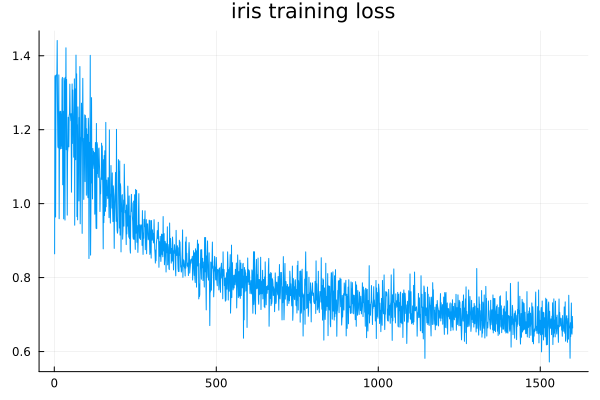

In [52]:
#train the parameters to predict iris
opt = Flux.setup( Flux.Adam(0.001) , model_iris ) |> gpu
losses = []
for epoch in 1:200
    for data_tmp in data    
        #get the gradients
        loss_tmp, grads = Flux.withgradient(model_iris) do model
            y_hat = model(data_tmp[1])
            Flux.crossentropy(y_hat,data_tmp[2])
        end
        Flux.update!(opt, model_iris, grads[1])
        push!(losses,loss_tmp) #don't put this in the above block where the gradient is computed
    end
end
p1 = plot( losses , title="iris training loss" , legend=false )
#savefig("./p1.png") #save the plot in the current directory
display(p1)

In [57]:
model_iris |> cpu
species |> cpu
x_train |> cpu
x_test |> cpu
y_train |> cpu
y_test |> cpu

hits = Flux.onecold( model_iris( x_train ) , species ) .== Flux.onecold( y_train , species )
accuracy = 100 * sum( hits ) / length( hits )
println( "Iris train accuracy = ", accuracy , "%" )

hits = Flux.onecold( model_iris( x_test ) , species ) .== Flux.onecold( y_test , species )
accuracy = 100 * sum( hits ) / length( hits )
println( "Iris test accuracy = ", accuracy , "%" )

Iris train accuracy = 96.0%
Iris test accuracy = 96.0%


<span style="color:orange">  </span>